In [253]:
import datetime as dt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler

## Download files

### Helper function to download files

In [203]:
def load_fred(series_id, start='1999-12-31'):
    """
    Fetch a single FRED series as a pandas Series.
    Uses the 'fredgraph.csv?id=SERIES' endpoint (no API key).
    Returns a Series indexed by datetime, named '<series_id>'.
    """
    url = f'https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}'
    df = pd.read_csv(url)
    # FRED returns columns ['DATE', '<series_id>']
    df.columns = ['DATE', series_id]
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df = df.set_index('DATE').sort_index()
    # Filter to start date
    df = df.loc[df.index >= pd.to_datetime(start)]
    # Coerce to numeric (FRED sometimes has '.')
    df[series_id] = pd.to_numeric(df[series_id], errors='coerce')
    return df[series_id]  # returns Series with 'Date' index

### Load data
- FRED: Federal Reserve Economic Data.
- SPX / NASDAQ: stock performance.
- Yields (2y, 10y, 30y, 3m): interest rates and Fed policy.
- VIX: market fear (volatility).
- CPI: Consumer Price Index, measures inflation (price level of goods and services)
- UNRATE: unemployment rate.
- INDPRO: industrial production index.

In [205]:
# 1) Load daily market + rates series 
spx   = load_fred('SP500')        # S&P 500 Index (close), daily
nasdq = load_fred('NASDAQCOM')    # NASDAQ (Tech-heavy index: Apple, Microsoft, ...) Composite, daily

# Rates (percent per annum):
# If short-term rates > long-term rates → yield curve inversion → often recession signal.
y10 = load_fred('DGS10')    # 10-Year Treasury yield, daily
y02 = load_fred('DGS2')     # 2-Year Treasury yield, daily
y30 = load_fred('DGS30')    # 30-Year Treasury yield, daily
y03m = load_fred('TB3MS')   # 3-Month Treasury bill, monthly (but FRED stores it at month-end or monthly stamps)

# Stress proxy (daily) (Volatility index), which measures expected stock market volatility over the next 30 days.
# Higher VIX = markets are fearful, expecting bigger swings
# Lower VIX = calmer markets
vix = load_fred('VIXCLS')   # CBOE VIX Index (close)

# 2) Load monthly macro series (monthly)
cpi    = load_fred('CPIAUCSL')  # measures inflation (price level of goods and services), monthly
unrate = load_fred('UNRATE')    # Unemployment rate (%), monthly
indpro = load_fred('INDPRO')    # Industrial Production Index, monthly

### Merge
Build a "trading-day-like" calendar as the intersection of daily market series:

In [211]:
daily = pd.DataFrame(
    index=spx.index.intersection(nasdq.index)
    .intersection(y10.index)
    .intersection(y02.index)
    .intersection(y30.index)
).sort_index()

### 1. Daily updated 

In [217]:
daily['SPX'] = spx
daily['NASDQ'] = nasdq
daily['Y10'] = y10
daily['Y02'] = y02
daily['Y30'] = y30
daily['VIX'] = vix

### 2. Monthly updated
We shift the release because economic data is published with a lag. Without the shift, we would accidentally give our model future knowledge.

Align by (approximate) release dates to avoid lookahead. If we naively forward-fill each month's value starting at the 1st of that month, we'd be leaking information. Solution: `shift` each macro series forward by a `fixed number of business days (BD)` to emulate the release date, then forward-fill.

- CPI release middle of next month: +15 business days
- UNRATE (Payrolls) release first Friday of next month: +7 business days
- INDPRO release mid-next-month: +15 business days
- TB3MS (3M T-bill monthly average): available shortly after month-end: +5 business days

In [219]:
def align_monthly_to_release(monthly_series, lag_bdays):
    s = monthly_series.copy()
    s = s.to_frame()
    s.columns = ['val']
    # Shift index forward by lag_bdays to approximate *release* date
    s['release_date'] = s.index + BDay(lag_bdays)
    s = s.set_index('release_date').sort_index()
    # Reindex to daily and forward-fill from release date until next release
    out = s.reindex(daily.index).ffill()['val']
    out.name = monthly_series.name
    return out

In [221]:
# Apply conservative approximations:
cpi_rel    = align_monthly_to_release(cpi,    lag_bdays=15)  # CPI: mid-next-month
unrate_rel = align_monthly_to_release(unrate, lag_bdays=7)   # unemployment: first Friday next month
indpro_rel = align_monthly_to_release(indpro, lag_bdays=15)  # INDPRO: mid-next-month
tb3m_rel   = align_monthly_to_release(y03m,   lag_bdays=5)   # 3M T-bill monthly avg: slightly after month-end

# Add to daily frame
daily['CPI'] = cpi_rel
daily['UNRATE'] = unrate_rel
daily['INDPRO'] = indpro_rel
daily['Y03M'] = tb3m_rel

In [223]:
raw = daily.copy()
# ffill and bfill missing values (macro series, holidays)
raw = raw.ffill()
raw = raw.bfill()

### Returns and basic features

Log returns are used below:


$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

In [225]:
# Empty data frame for features
features = pd.DataFrame(index=daily.index)

# Stress/Liquidity proxy (since no volume in FRED, we use VIX)
features['vix_level'] = raw.VIX

def log_return(s, lag=1):
    return np.log(s / s.shift(lag))

# Momentum (trend): log return over short and long windows
for lag in (1, 5, 21, 63):
    features[f'lag_{lag}_return_spx'] = log_return(raw.SPX, lag=lag)
    features[f'lag_{lag}_return_nasdq'] = log_return(raw.NASDQ, lag=lag)

# Divide by 100: Bond yields in FRED are in percent
# Negative sign: Bond prices move inversely to yields.
features['bond_proxy_1d'] = - (raw.Y10 - raw.Y10.shift(1)) / 100

# Realized volatility (rolling std of 1d returns)
features['rVolatility_21_spx'] = features.lag_1_return_spx.rolling(21).std()
features['rVolatility_21_nasdq'] = features.lag_1_return_nasdq.rolling(21).std()

### Correlation signals (60d rolling)

- Equity–Equity (SPX–NASDAQ): stock indices usually move together, so correlation stays positive and stable.  
- Equity–Bond (SPX vs bond proxy): correlation depends on regime:  
  - Risk-on: stocks ↑, bonds ↓ (yields ↑): negative corr.  
  - Risk-off: stocks ↓, bonds ↑ (yields ↓): negative corr.  
  - Crisis/liquidity stress: stocks ↓, bonds ↓ (yields ↑): positive corr.

We track this with a 60-day rolling Pearson correlation to capture regime shifts.

In [227]:
def rolling_corr(a, b, win=60):
    return a.rolling(win).corr(b)

features['corr_spx_nasdq_60'] = rolling_corr(
    features.lag_1_return_spx, 
    features.lag_1_return_nasdq,
    win=60
)
features['corr_spx_bondpx_60'] = rolling_corr(
    features.lag_1_return_spx, 
    features.bond_proxy_1d,
    win=60
)

### Yield-curve factors: Level / Slope / Curvature

1. Level: overall yield level (use $10y$).
2. Slope: term spread between long and short rates ($10y - 3m$):
    - Steep slope ($10y ≫ 3m$): long rates much higher than short i.e. economy growing, policy easy.  
    - Flat or inverted slope ($10y ≈ 3m$ or  $< 3m$): long rates not above short i.e. economy slowing, possible stress or recession.  
3. Curvature: how "bent" the curve is ($2y + 30y - 2*10y$). Changes in curvature can signal non-parallel shifts.

In [230]:
features['yc_level_10y'] = raw['Y10']     # Level                     
features['yc_slope_10y_3m'] = raw['Y10'] - raw['Y03M']  # Slope    
features['yc_curv_2y_10y_30y'] = raw['Y02'] + raw['Y30'] - 2 * raw['Y10'] # Curvature

### Macroeconomic variables

In [232]:
features['cpi_yoy'] = (raw.CPI / raw.CPI.shift(252) - 1) * 100 
features['unemp_lvl'] = raw.UNRATE                                         
features['unemp_diff_21'] = raw.UNRATE - raw.UNRATE.shift(21)              
features['indpro_yoy'] = (raw.INDPRO / raw.INDPRO.shift(252) - 1) * 100

In [234]:
features.isnull().sum()

vix_level                 0
lag_1_return_spx          1
lag_1_return_nasdq        1
lag_5_return_spx          5
lag_5_return_nasdq        5
lag_21_return_spx        21
lag_21_return_nasdq      21
lag_63_return_spx        63
lag_63_return_nasdq      63
bond_proxy_1d             1
rVolatility_21_spx       21
rVolatility_21_nasdq     21
corr_spx_nasdq_60        60
corr_spx_bondpx_60       60
yc_level_10y              0
yc_slope_10y_3m           0
yc_curv_2y_10y_30y        0
cpi_yoy                 252
unemp_lvl                 0
unemp_diff_21            21
indpro_yoy              252
dtype: int64

### Winsorization (1% tails)
Fat tails can destabilize PCA/cluster scaling, so we clip extreme outliers.

In [236]:
winsor_cols = [
    'lag_1_return_spx', 'lag_1_return_nasdq',
    'lag_5_return_spx','lag_5_return_nasdq',
    'lag_21_return_spx','lag_21_return_nasdq',
    'lag_63_return_spx','lag_63_return_nasdq',
    'bond_proxy_1d', 'rVolatility_21_spx',
    'rVolatility_21_nasdq', 'vix_level',
    'corr_spx_nasdq_60','corr_spx_bondpx_60'
]

def winsorize(s, lower=0.01, upper=0.99):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lo, hi)

for col in winsor_cols:
    if col in features:
        features[col] = winsorize(features[col])

### Standardization

In [238]:
scaler = StandardScaler()
std_cols = [col for col in features.columns]

# Drop NaNs before standard scaler
features_cleaned = features.dropna(subset=std_cols)

features_std = pd.DataFrame(
    scaler.fit_transform(features_cleaned[std_cols]),
    index=features_cleaned.index, columns=[col + '_z' for col in std_cols]  # suffix _z
)

# Attach standardized columns (suffix _z). Keep both raw and z-scored for later interpretation.
features_all = pd.concat([features_cleaned, features_std], axis=1)

In [166]:
features_all.columns

Index(['vix_level', 'lag_1_return_spx', 'lag_1_return_nasdq',
       'lag_5_return_spx', 'lag_5_return_nasdq', 'lag_21_return_spx',
       'lag_21_return_nasdq', 'lag_63_return_spx', 'lag_63_return_nasdq',
       'bond_proxy_1d', 'rVolatility_21_spx', 'rVolatility_21_nasdq',
       'corr_spx_nasdq_60', 'corr_spx_bondpx_60', 'yc_level_10y',
       'yc_slope_10y_3m', 'yc_curv_2y_10y_30y', 'cpi_yoy', 'unemp_lvl',
       'unemp_diff_21', 'indpro_yoy', 'vix_level_z', 'lag_1_return_spx_z',
       'lag_1_return_nasdq_z', 'lag_5_return_spx_z', 'lag_5_return_nasdq_z',
       'lag_21_return_spx_z', 'lag_21_return_nasdq_z', 'lag_63_return_spx_z',
       'lag_63_return_nasdq_z', 'bond_proxy_1d_z', 'rVolatility_21_spx_z',
       'rVolatility_21_nasdq_z', 'corr_spx_nasdq_60_z', 'corr_spx_bondpx_60_z',
       'yc_level_10y_z', 'yc_slope_10y_3m_z', 'yc_curv_2y_10y_30y_z',
       'cpi_yoy_z', 'unemp_lvl_z', 'unemp_diff_21_z', 'indpro_yoy_z'],
      dtype='object')

## PCA and KMeans Clustering

In [255]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

plt.style.use('default')

In [242]:
# Pick standardized features
X = features_all[[col for col in features_all.columns if col.endswith('_z')]]
print('Using', X.shape[1], 'standardized features on', X.shape[0], 'days.')
X.columns

Using 21 standardized features on 2356 days.


Index(['vix_level_z', 'lag_1_return_spx_z', 'lag_1_return_nasdq_z',
       'lag_5_return_spx_z', 'lag_5_return_nasdq_z', 'lag_21_return_spx_z',
       'lag_21_return_nasdq_z', 'lag_63_return_spx_z', 'lag_63_return_nasdq_z',
       'bond_proxy_1d_z', 'rVolatility_21_spx_z', 'rVolatility_21_nasdq_z',
       'corr_spx_nasdq_60_z', 'corr_spx_bondpx_60_z', 'yc_level_10y_z',
       'yc_slope_10y_3m_z', 'yc_curv_2y_10y_30y_z', 'cpi_yoy_z', 'unemp_lvl_z',
       'unemp_diff_21_z', 'indpro_yoy_z'],
      dtype='object')

### 1. Principal Component Analysis (PCA)


Expalined variance ratio by PC:
PC1: 25.19%
PC2: 15.30%
PC3: 14.35%
PC4: 10.84%
PC5: 6.34%
PC6: 5.20%
PC7: 4.98%
PC8: 4.36%
PC9: 3.43%
PC10: 2.55%
PC11: 1.95%
PC12: 1.72%
PC13: 1.06%
PC14: 0.80%
PC15: 0.61%
PC16: 0.44%
PC17: 0.29%
PC18: 0.25%
PC19: 0.15%
PC20: 0.10%
PC21: 0.09%
Minimum PCs for ≥70% variance explained: 5
Total variance explained by 5 PCs: 72.02%
Explained variance by PC1+PC2+PC3: 54.84%


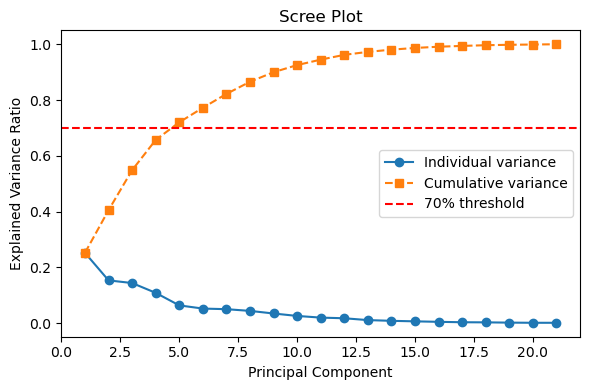

In [244]:
# Fit PCA
pca = PCA()
pca.fit(X)
exp_var = pca.explained_variance_ratio_
cum_var = exp_var.cumsum()

print('\nExpalined variance ratio by PC:')
sum=0
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    sum += var
    print(f'PC{i}: {var:.2%}')

# Find minimum #PCs to reach at least 70% variance explained
target_var = 0.70
n_required = np.argmax(cum_var >= target_var) + 1
print(f'Minimum PCs for ≥70% variance explained: {n_required}')
print(f'Total variance explained by {n_required} PCs: {cum_var[n_required-1]:.2%}')

# Also print variance explained by PC1+PC2+PC3
top3_var = exp_var[:3].sum()
print(f'Explained variance by PC1+PC2+PC3: {top3_var:.2%}')

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(exp_var)+1), exp_var, marker='o', label='Individual variance')
plt.plot(range(1, len(exp_var)+1), cum_var, marker='s', linestyle='--', label='Cumulative variance')
plt.axhline(y=target_var, color='red', linestyle='--', label='70% threshold')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

- PC1–3 together explain ~55% of the variance (25% + 15% + 14%).  
- PC1–5 explain ~72% in total, crossing the 70% threshold.  
- After PC5, additional components each add <7% and quickly taper off.  
- Dimensionality: keep the first 3 PCs for analysis, as they help with interpretability.

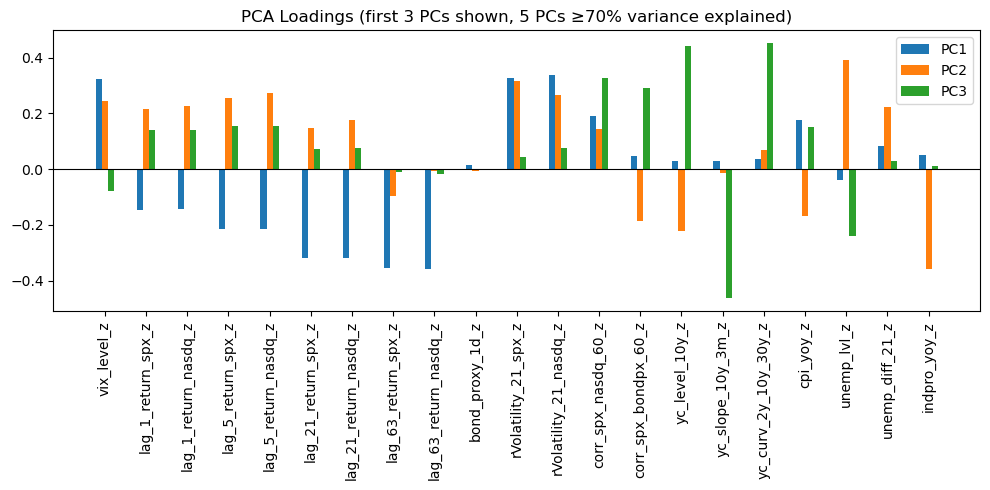

In [246]:
# PCA loadings: show first 3 PCs
n_features = len(X.columns)
x = np.arange(n_features)
width = 0.15
n_to_plot = min(3, pca.components_.shape[0])

plt.figure(figsize=(10,5))
for i in range(n_to_plot):
    plt.bar(
        x + i*width - (width*(n_to_plot-1)/2),
        pca.components_[i],
        width=width,
        label=f'PC{i+1}'
    )
plt.xticks(x, X.columns, rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f'PCA Loadings (first {n_to_plot} PCs shown, {n_required} PCs ≥70% variance explained)')
plt.legend()
plt.tight_layout()
plt.show()

### Interpreting the first 3 PCs  

#### PC1 (~25%)  
PC1 is the equity risk / stress factor. 
- Positive direction (high PC1 scores): strong loadings on VIX and realized volatility, negative loadings on SPX/NASDAQ returns across all lags.  
- High PC1 = risk-off markets: equities falling, volatility spiking.  
- Low PC1 = risk-on markets: equities rising, volatility subdued.  

#### PC2 (~15%)  
PC2 contrasts market stress (volatility, unemployment, fear) against macro strength (production, inflation, healthy yield curve).  

- High PC2 scores: turbulent, fearful markets with rising unemployment, high volatility, and very negative stock–bond correlation (flight-to-safety: equities sell off, Treasuries rally).  
- Low PC2 scores: stable growth with stronger production, moderately higher inflation, steeper yield curve, and less negative stock–bond correlation (hedge weaker, typical of calmer conditions).  

*Note:* Textbooks often emphasize positive stock–bond correlation in crises (inflationary crises).  
But in this dataset, crises appear instead as negative correlations because Treasuries acted as a strong safe haven (deflationary crisis).

#### PC3 (~14%)  
PC3 contrasts unusual yield-curve dynamics and high rates/curvature against healthy macro signals (growth, jobs, steep curve).  
- Positive direction (high PC3 scores) indicates stressed bond market structure: high yield-curve curvature and elevated long-term yields (10y), alongside volatility.  
- Negative direction (low PC3 scores) indicates more normal macro growth regime: steep yield curve (10y–3m slope), improving labor markets (falling unemployment), and stronger industrial production.  


In [248]:
# Reduce dataset to 2 PCs

pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X)
print('\nExplained variance by PC1+PC2:', round(pca_2.explained_variance_ratio_.sum(), 3))


Explained variance by PC1+PC2: 0.405


### 2. Clustering


Cluster Profiles:
         lag_1_return_spx  rVolatility_21_spx  vix_level  corr_spx_bondpx_60  \
Regime                                                                        
0                 -0.005               0.014     25.417              -0.071   
1                  0.007               0.019     29.024              -0.400   
2                  0.001               0.007     15.566              -0.165   

        yc_level_10y  yc_slope_10y_3m  unemp_lvl  cpi_yoy  
Regime                                                     
0              2.980            0.636      3.931    4.974  
1              1.329            0.523      9.117    1.410  
2              2.789            0.398      4.326    2.852  

Cluster Sizes:
         Size Percent
Regime              
0        483   20.5%
1        156    6.6%
2       1717   72.9%

Markov Transition Matrix:
 Regime     0     1     2
Regime                  
0.0     0.81  0.05  0.14
1.0     0.11  0.78  0.11
2.0     0.04  0.01  0.95

Regime D

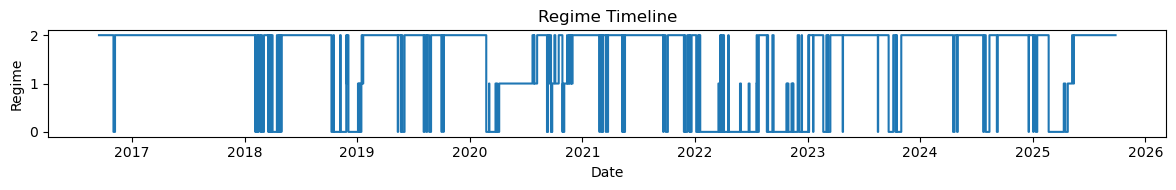

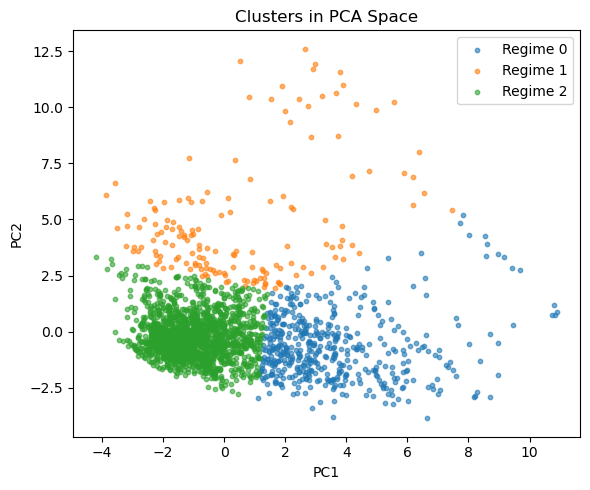

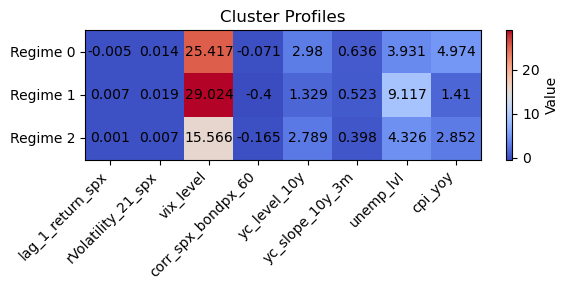

In [250]:
# KMeans Clustering (3 regimes)
k = 3  
km = KMeans(n_clusters=k, random_state=0, n_init=20)
feat_df = features_all.copy()
feat_df['Regime'] = km.fit_predict(X_pca[:, :3])  

# Cluster Profiles + Sizes
profile_cols = [
    'lag_1_return_spx',      # equity short-term return (direction)
    'rVolatility_21_spx',    # realized vol (calm vs turbulent)
    'vix_level',             # implied vol / fear
    'corr_spx_bondpx_60',    # equity-bond correlation (risk-on vs flight-to-safety)
    'yc_level_10y',          # rate environment (low vs high yields)
    'yc_slope_10y_3m',       # cycle position (steep vs inverted curve)
    'unemp_lvl',             # labor market stress (macro anchor)
    'cpi_yoy'                # inflation anchor
]
profiles = feat_df.groupby('Regime')[profile_cols].mean().round(3)
sizes = feat_df['Regime'].value_counts().sort_index()
sizes_table = pd.DataFrame({
    'Size': sizes,
    'Percent': (sizes/len(feat_df)*100).round(1).astype(str)+'%'
})

print('\nCluster Profiles:\n', profiles)
print('\nCluster Sizes:\n', sizes_table)

# Markov Transition Matrix (between regimes)
transitions = pd.crosstab(feat_df['Regime'].shift(), 
                          feat_df['Regime'], 
                          normalize='index').round(2)
transitions.to_csv('regime_transitions.csv')
print('\nMarkov Transition Matrix:\n', transitions)

# Regime Durations
feat_df['Regime_shift'] = feat_df['Regime'].shift()
feat_df['new_block'] = (feat_df['Regime'] != feat_df['Regime_shift']).cumsum()
durations = (feat_df.groupby(['Regime','new_block']).size()
             .groupby('Regime').agg(['mean','median']).round(1))
print('\nRegime Durations (days):\n', durations)

# Timeline
plt.figure(figsize=(12,2))
plt.plot(feat_df.index, feat_df['Regime'], drawstyle='steps-post')
plt.title('Regime Timeline')
plt.xlabel('Date')
plt.ylabel('Regime')
plt.tight_layout()

# Scatter in PCA space (first 2 PCs)
plt.figure(figsize=(6,5))
for r in range(k):
    mask = feat_df['Regime'] == r
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=10, alpha=0.6, label=f'Regime {r}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters in PCA Space')
plt.legend()
plt.tight_layout()

# Heatmap of cluster profiles
plt.figure(figsize=(6,3))
plt.imshow(profiles, cmap='coolwarm', aspect='auto')
plt.xticks(range(len(profiles.columns)), profiles.columns, rotation=45, ha='right')
plt.yticks(range(len(profiles.index)), [f'Regime {r}' for r in profiles.index])
for i in range(len(profiles)):
    for j in range(len(profiles.columns)):
        plt.text(j, i, str(profiles.iloc[i, j]), ha='center', va='center')
plt.colorbar(label='Value')
plt.title('Cluster Profiles')
plt.tight_layout()

### Interpreting the Three Regimes

Using the PCA scatter plot (PC1 vs. PC2), cluster profile heatmap, regime sizes, transition probabilities, durations, and timeline, we can characterize the regimes as follows:


#### Regime 1 (orange, ~7%)
- Position in PCA space: highest along PC2.  
- Profile (heatmap):
  - Very high VIX (29.1) and realized volatility.  
  - Strongly negative stock–bond correlation (≈ –0.4): bonds rally as equities sell off (classic flight-to-safety).  
  - High unemployment (≈ 9), weak inflation (≈ 1.4%).  
- Persistence and size: only 6.6% of observations, mean duration ≈ 4.5 days (median 1 day), but ~78% chance of staying once entered.  
- Timeline: Appears around late 2018 (Fed tightening shock), early 2020 (COVID crash), and spikes in 2022–2023.  
- Interpretation: 
  This is a deflationary crisis regime. Markets experience systemic stress with equities collapsing, volatility spiking, labor markets weakening, and Treasuries providing a safe haven.  
  - Different from inflationary crises: instead of equities and bonds falling together, here bonds rally strongly, driving correlation deeply negative.  

#### Regime 0 (blue, ~20%)
- Position in PCA space: mid PC2, but high PC1 values.  
- Profile (heatmap):  
  - Moderately high VIX (25).  
  - Mildly negative stock–bond correlation (≈ –0.07): bonds hedge, but less strongly than in Regime 1.  
  - Unemployment moderate (≈ 4), inflation ≈ 5%.  
- Persistence and size: 20.5% of observations, mean duration ≈ 5.2 days (median 2 days), with ~81% persistence.  
- Interpretation:
  This is a risk-off but non-crisis regime. Equities sell off, volatility rises, but bonds remain a hedge. It reflects flight-to-quality episodes typical of market corrections, not systemic crashes.  


#### Regime 2 (green, ~73%)
- Position in PCA space: lowest PC1 and PC2 values.  
- Profile (heatmap):  
  - Lowest VIX (15.6) and realized volatility.  
  - Negative stock–bond correlation (≈ –0.17).  
  - Unemployment relatively low (≈ 4.3), inflation moderate (≈ 2.8%).  
- Persistence and size: 72.9% of observations, mean duration ≈ 19.3 days (median 3 days), with a very high 95% persistence probability.  
- Interpretation:  
  This is the risk-on / stable growth regime. Equities rise, volatility is subdued, bonds hedge equities, and macro fundamentals are supportive. It dominates the sample, reflecting the long-run “normal” state of markets.  
